In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams["savefig.dpi"] = 96
rcParams["figure.dpi"] = 96

# The polynomial decomposition

## Introduction

The polynomial decomposition approach was originally proposed by [Keery et al. (2012)](
https://doi.org/10.1190/geo2011-0244.1). It consists of performing Debye decomposition of the SIP spectra with the assumption that the relaxation time distribution (RTD) of that spectra can be approximated by a polynomial function. In this approach, the complex resistivity $\rho^*$ is given by 

\begin{equation}
\rho^* = \rho_0 \left[ 1 - \sum_{l=1}^{L} m_l\left(1-\frac{1}{1+(i\omega\tau_l)} \right) \right],
\end{equation}

where $\omega$ is the measurement angular frequencies
($\omega=2\pi f$) and $i$ is the imaginary unit. BISIP uses a generalized Cole-Cole polynomial decomposition scheme by including a user-defined Cole-Cole exponent ($c$). If $c = 1$, the equation is equivalent to Debye decomposition. If $c=0.5$, the equation is known as Warburg decomposition. For any other values we refer to this scheme as the generalized Cole-Cole decomposition. The complex resistivity is thus given by

\begin{equation}
\rho^* = \rho_0 \left[ 1 - \sum_{l=1}^{L} m_l\left(1-\frac{1}{1+(i\omega\tau_l)^c} \right) \right],
\end{equation}

where $L$ is an arbitrary real number that defines the discretization level of the RTD. In practice BISIP uses $L = 2\times n_{freq}$, where $n_{freq}$ is the number of measurement points in the frequency range. The RTD is defined by the distribution of $m_l$ values as a function of $\tau_l$ values. According to [Keery et al. (2012)](https://doi.org/10.1190/geo2011-0244.1), the RTD can be written as

\begin{equation}
m_l = \sum_{p=0}^P a_p (\log_{10} \tau_l)^p,
\end{equation}

where $a_p$ are polynomial coefficients and $P$ is the polynomial degree of the approximation. In practice, $P$ is often set to 3, 4 or 5. The user should aim to use the lowest degree possible while maintaining a satisfying fit with the data. As a result, $\rho^*$ depends on $P+1$ parameters:

- $\rho_0 \in [0, \infty)$, the direct current resistivity $\rho_0 = \rho^*(\omega\to 0)$.
- $a_p$, the $P$ polynomial coefficients.

From the recovered $a_p$ and $\rho_0$ values, the user can then compute the RTD and extract several integrating parameters, such as total chargeability and mean relaxation time. The user is referred to [Keery et al. (2012)](https://doi.org/10.1190/geo2011-0244.1) for the definition of these parameters. In this tutorial, we will compare the total chargeability values obtained with Debye and Warburg decomposition for 5 rock samples.

## Debye decomposition

First import the required packages.

In [2]:
import numpy as np
from bisip import PolynomialDecomposition
from bisip import DataFiles

np.random.seed(42)

Let's start by inspecting the data sets so we can decide which polynomial approximation would be appropriate to fit the observations.

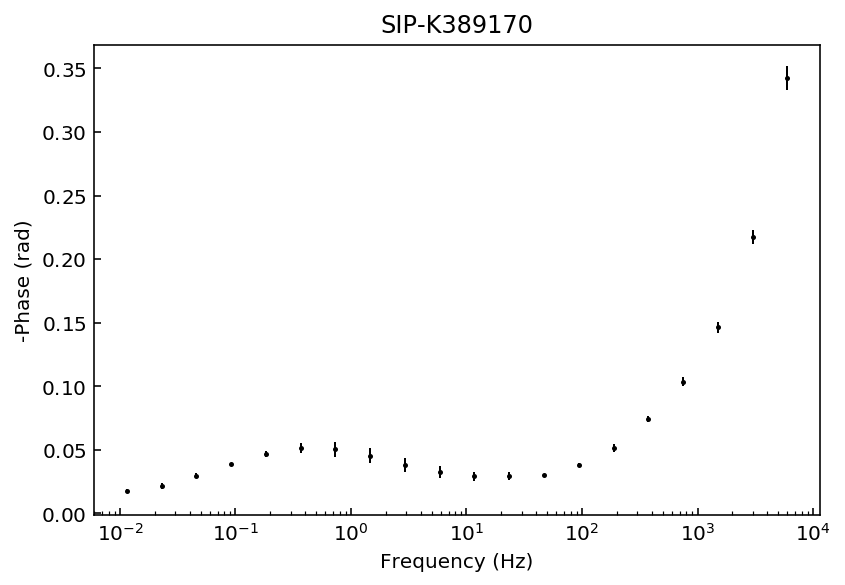

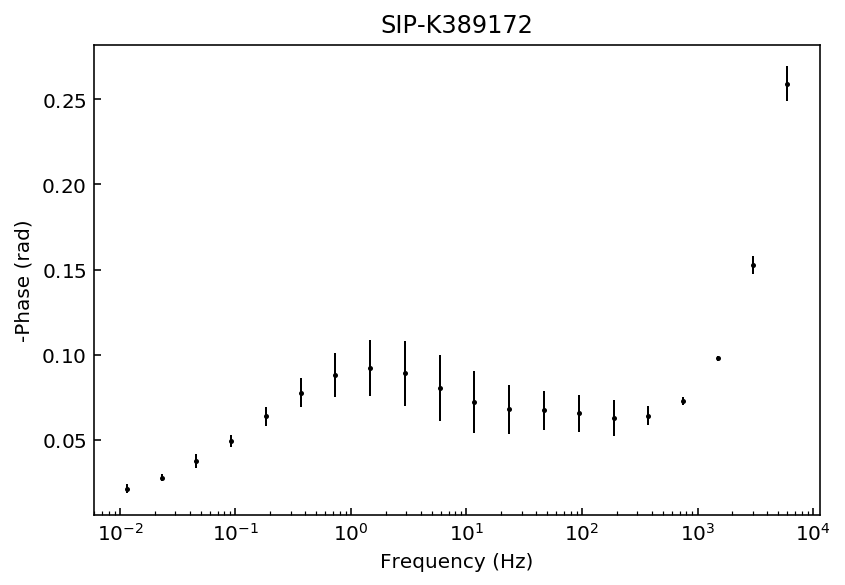

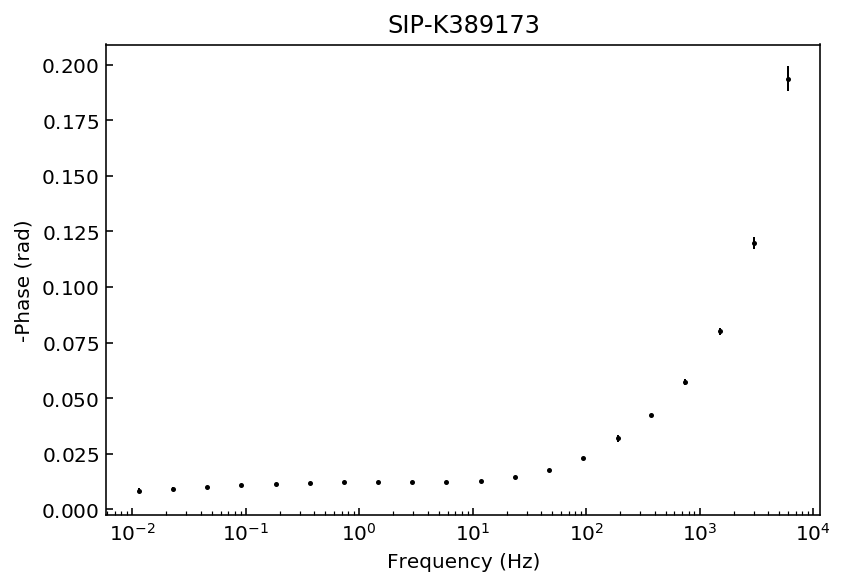

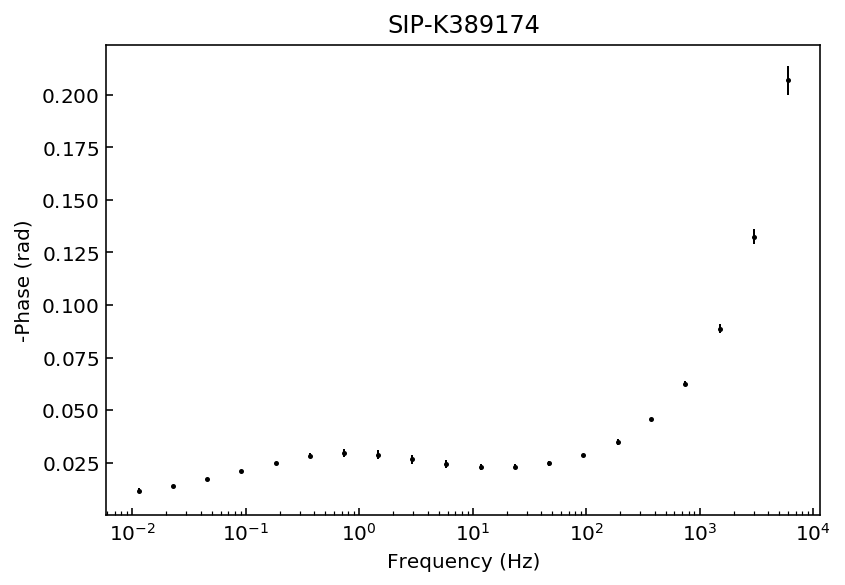

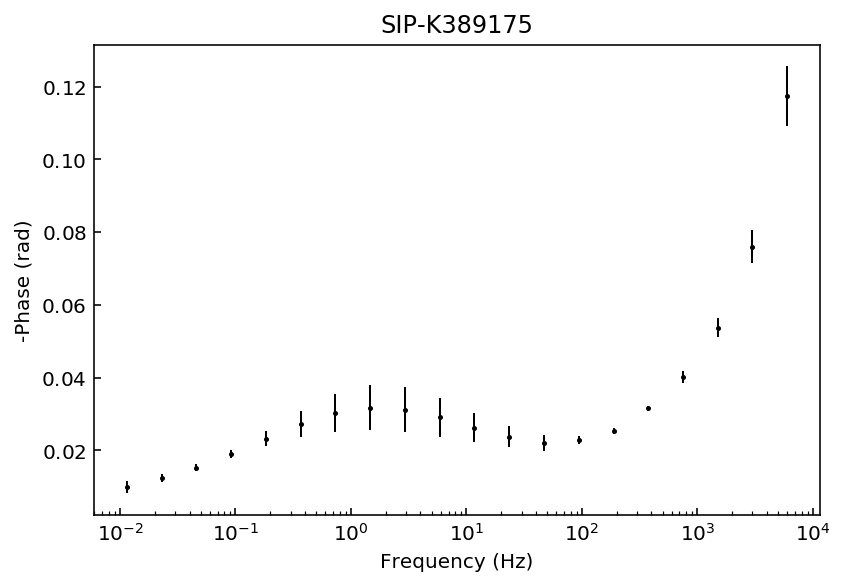

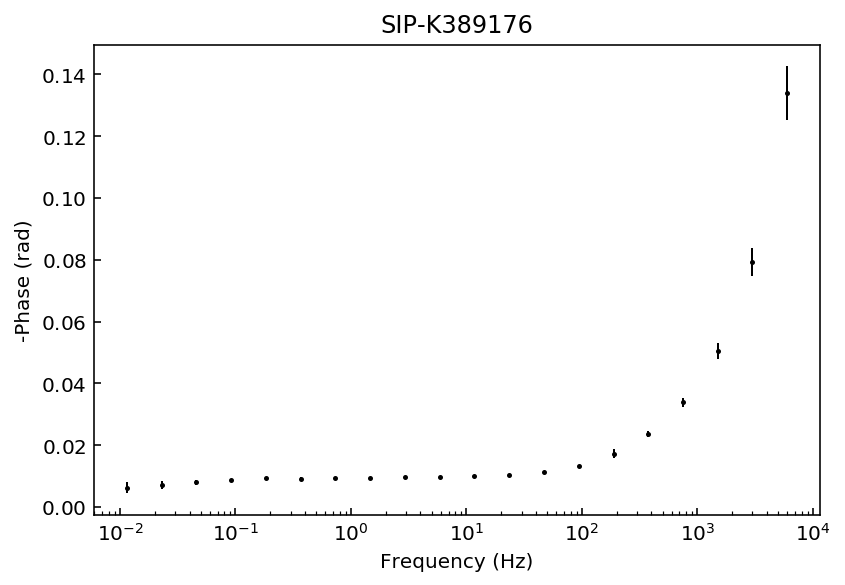

In [5]:
data_files = DataFiles()  # get the dictionary of BISIP data files

for n, p in data_files.items():  # n is the filename, p the filepath
    model = PolynomialDecomposition(filepath=p)
    fig = model.plot_data('phase')
    ax = fig.gca()
    ax.set_title(n)

Samples K389173 and K389176 can be explained with a 3rd degree polynomial approxation, whereas the rest of the samples would likely require a 4th order polynomial approximation. For this example we will use a 4th order approaximation for all data sets.

In [7]:
# Make a dict to hold results
results_debye = {}
# Define MCMC and Debye parameters
params = {'nwalkers': 32,
          'nsteps': 1000,
          'c_exp': 1,
          'poly_deg': 4,
         }

for n, p in data_files.items():  # n is the filename, p the filepath
    # Initialize with 1 file at a time, and pass the params
    model = PolynomialDecomposition(filepath=p, **params)
    model.fit()
    # Store the fitted model in the results dict
    results_debye[n] = model

100%|██████████| 1000/1000 [00:01<00:00, 503.92it/s]


Now we have a dictionary of fitted models in `results_debye`. Let's quickly inspect the fit results while discarding half the steps as burn-in. Check the chains with the `plot_traces()` method to see why the value is appropriate.

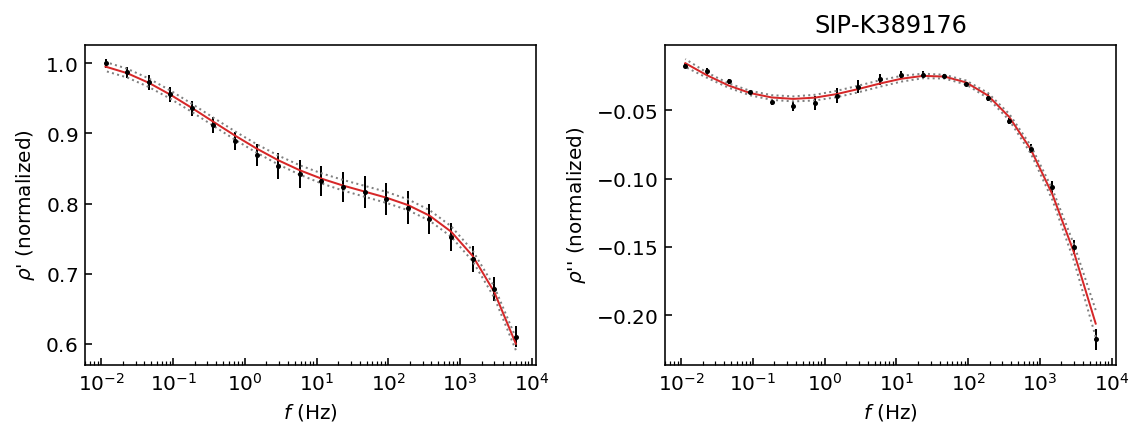

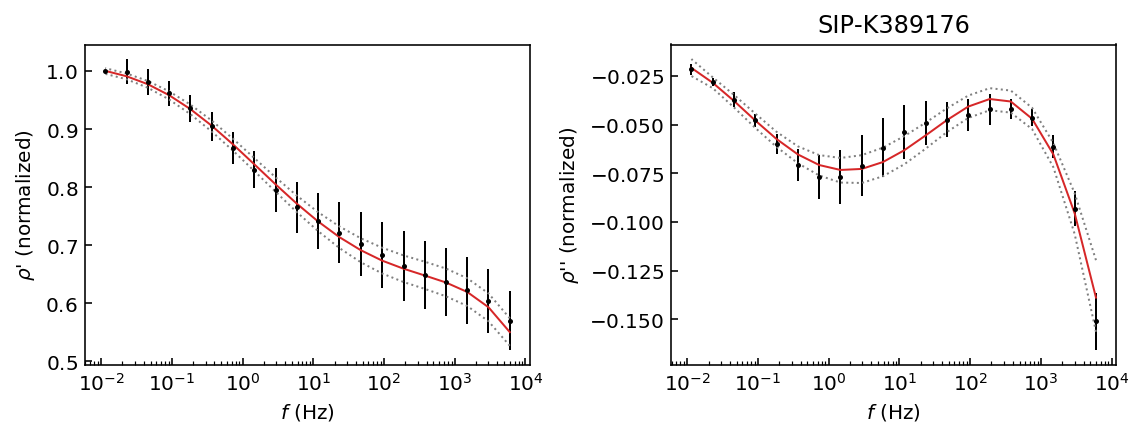

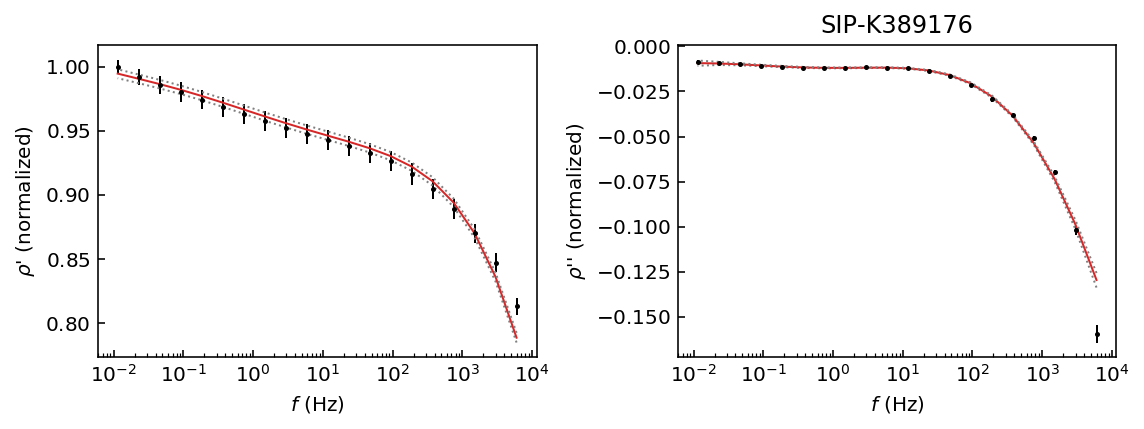

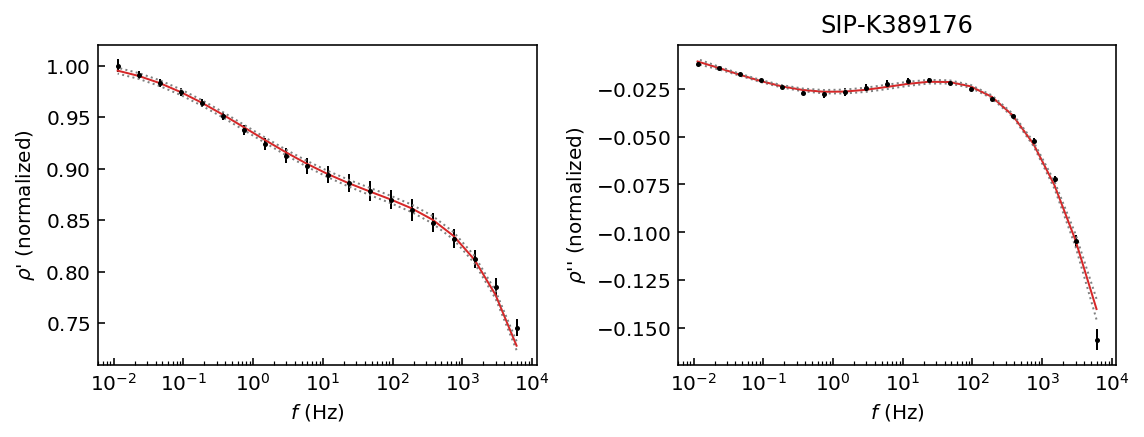

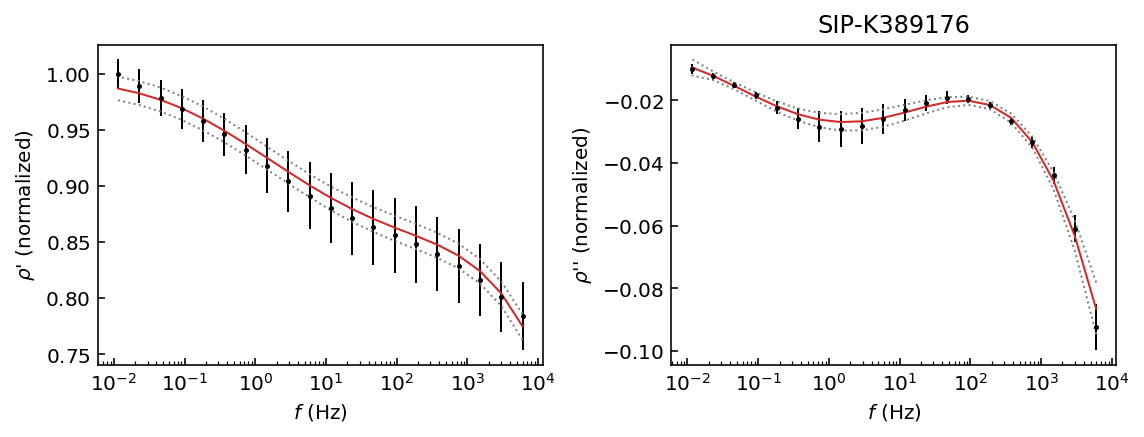

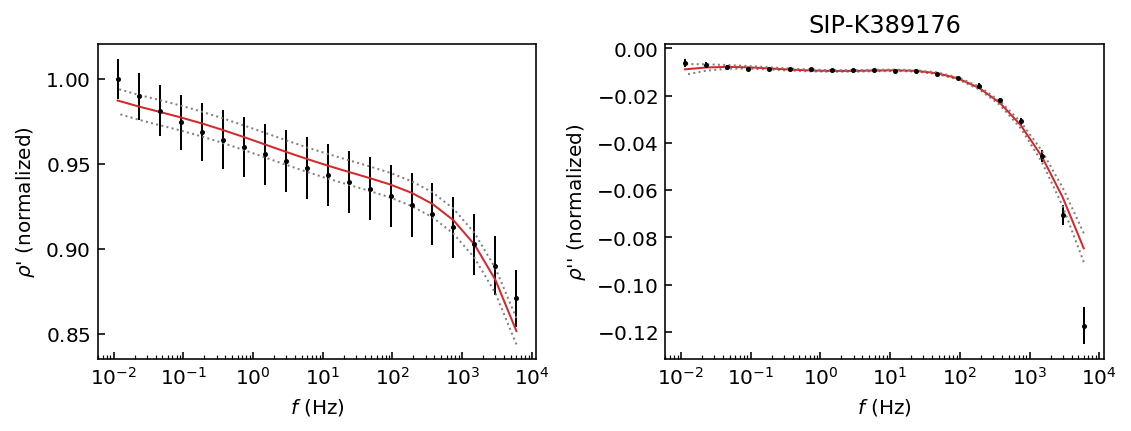

In [9]:
for name, model in results_debye.items():
    fig = model.plot_fit(discard=500)
    ax = fig.gca()
    ax.set_title(n)

We need to do a bit of work to extract the total chargeability. We will use the chargeability equation and the pandas library to organize the results.

In [41]:
import pandas as pd

names = list(results_debye.keys())
models = list(results_debye.values())

mean_values = [m.get_param_mean(discard=500) for m in models]

df_debye = pd.DataFrame(mean_values)
df_debye.columns= models[0].param_names
df_debye.index = names
df_debye.head()

,r0,a0,a1,a2,a3,a4
SIP-K389170,0.990191,0.014054,-0.002331,-0.004639,-0.000346,0.000217
SIP-K389172,1.020714,0.017539,-0.011597,-0.003418,0.002129,0.000537
SIP-K389173,1.011353,0.003399,-0.000986,-0.000509,0.000387,0.000170
SIP-K389174,1.004475,0.007557,-0.003181,-0.001887,0.000535,0.000240
SIP-K389175,0.997523,0.006863,-0.003920,-0.001335,0.000734,0.000217


We need to sum the coefficients and log_tau values:

\begin{equation}
m_l = \sum_{p=0}^P a_p (\log_{10} \tau_l)^p.
\end{equation}

In [36]:
# Take log_tau from any model (considering the 
# frequency range is the same for all samples)
log_tau = models[0].log_tau
print(log_tau)

[-6.         -5.79487179 -5.58974359 -5.38461538 -5.17948718 -4.97435897
 -4.76923077 -4.56410256 -4.35897436 -4.15384615 -3.94871795 -3.74358974
 -3.53846154 -3.33333333 -3.12820513 -2.92307692 -2.71794872 -2.51282051
 -2.30769231 -2.1025641  -1.8974359  -1.69230769 -1.48717949 -1.28205128
 -1.07692308 -0.87179487 -0.66666667 -0.46153846 -0.25641026 -0.05128205
  0.15384615  0.35897436  0.56410256  0.76923077  0.97435897  1.17948718
  1.38461538  1.58974359  1.79487179  2.        ]


In [98]:
def get_m(df, P):
    m = {}
    for idx in df.index:  
        m[idx] = 0
        for p in range(P+1):        
            coeff = df_debye.loc[idx, f'a{p}']
            m[idx] += coeff*log_tau**p 
        # Add the total chargeability in the df
        df.loc[idx, 'total_m'] = np.sum(m[idx]) 
    return m

m_debye = get_m(df_debye, params['poly_deg'])


Let's inspect the recovered RTDs:

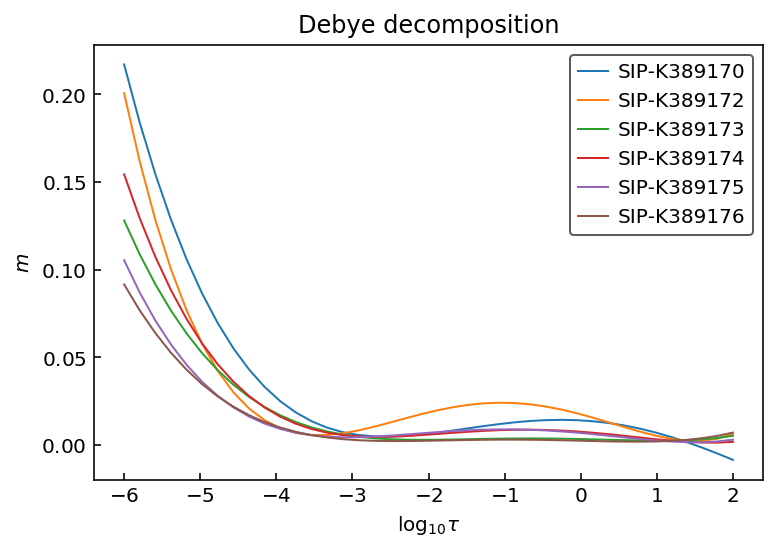

In [134]:
import matplotlib.pyplot as plt

for n in names:
    plt.plot(log_tau, m_debye[n], label=n)
    plt.ylabel(r'$m$')
    plt.xlabel(r'$\log_{10} \tau$')
plt.title('Debye decomposition')
plt.legend()

## Warburg decomposition

Now we will repeat these steps for a Warburg decomposition ($c = 0.5$).

In [102]:
# Make a dict to hold results
results_warburg = {}
# Define MCMC and Debye parameters
params = {'nwalkers': 32,
          'nsteps': 1000,
          'c_exp': 0.5,
          'poly_deg': 4,
         }

for n, p in data_files.items():  # n is the filename, p the filepath
    # Initialize with 1 file at a time, and pass the params
    model = PolynomialDecomposition(filepath=p, **params)
    model.fit()
    # Store the fitted model in the results dict
    results_warburg[n] = model

100%|██████████| 1000/1000 [00:03<00:00, 263.14it/s]


In [106]:
names = list(results_warburg.keys())
models = list(results_warburg.values())

mean_values = [m.get_param_mean(discard=500) for m in models]

df_warburg = pd.DataFrame(mean_values)
df_warburg.columns= models[0].param_names
df_warburg.index = names

m_warburg = get_m(df_warburg, params['poly_deg'])

In [128]:
df = pd.DataFrame()
df['debye_total_m'] = df_debye['total_m']
df['warburg_total_m'] = df_warburg['total_m']

In [131]:
df.head(6)

,debye_total_m,warburg_total_m
SIP-K389170,1.34071,1.340710
SIP-K389172,1.22183,1.221832
SIP-K389173,0.785468,0.785468
SIP-K389174,0.930222,0.930222
SIP-K389175,0.652685,0.652685
SIP-K389176,0.544773,0.544773


The values are identical.

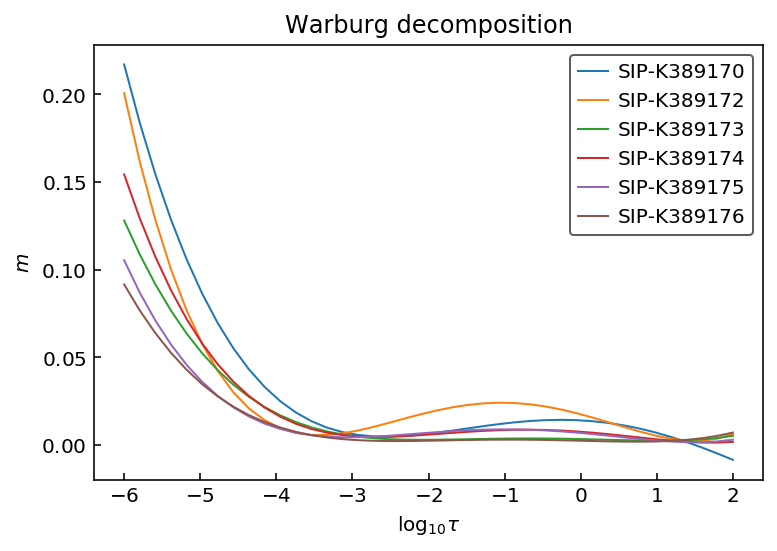

In [133]:
for n in names:
    plt.plot(log_tau, m_warburg[n], label=n)
    plt.ylabel(r'$m$')
    plt.xlabel(r'$\log_{10} \tau$')
plt.title('Warburg decomposition')
plt.legend()

## Conclusions

In this tutorial we have seen how to do batch inversions and organize the results in pandas DataFrames and how to extract integrating parameters from the polynomial decomposition approach. The total chargeability parameter was identical for Debye and Warburg decomposition approaches.